In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from datetime import datetime
from scipy.stats import linregress, chisquare
from sklearn.linear_model import LinearRegression

### Section 3
Propose a project to do while at The Data Incubator. We want to know about your ability to think at a high level. Try to think of projects that users or businesses will care about that are also relatively unanalyzed.

Propose a project that uses a large, publicly accessible dataset. Explain your motivation for tackling this problem, discuss the data source(s) you are using, and explain the analysis you are performing. 

### Project Ideas

Each year, many foreign workers are employed by American companies that are trying to fill positions that require special knowledge or education. These companies need to apply H1-B to those foreign workers which give workers authorization to work in the US. It is often a tedious and troublesome process. Therefore, I am proposing to have a Machine Learning model to predict the likelihood that if a person will be accepted to the H1-B program prior applying. It also gives suggestions to companies that should be changed in the applications to order to increase the chances of getting H1-B visa. Since the cost time and money for each denied H1-B case, the machine learning model aims to help business to save time and focus on more important tasks to worry.

From the first graph, it shows that most H1-B decisions are irrelevent to its salaries. I am a bit surprised by this result because I assumed that a higher paying job would usually mean a more specialized job that would requires a better approval chance.

The second graph shows that the average length of decisions. For the most part, it takes somewhere from 4 to 8 days to approve H1-B applications with median of 6 days to hear back. However, your case is denied, it will reply within with 10 days. 

https://www.kaggle.com/trivedicharmi/h1b-disclosure-dataset/home

In [26]:
h1b_data = pd.read_csv('1. Master H1B Dataset.csv',
                       encoding = "ISO-8859-1")

C:\Users\Siu Ka\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
h1b_data.head()

,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIEDWITHDRAWN
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,WITHDRAWN
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIEDWITHDRAWN


In [28]:
h1b_data.nunique()

CASE_SUBMITTED_DAY          31
CASE_SUBMITTED_MONTH        12
CASE_SUBMITTED_YEAR          7
DECISION_DAY                31
DECISION_MONTH               9
DECISION_YEAR                2
VISA_CLASS                   4
EMPLOYER_NAME            61103
EMPLOYER_STATE              56
EMPLOYER_COUNTRY             4
SOC_NAME                    56
NAICS_CODE                2030
TOTAL_WORKERS               52
FULL_TIME_POSITION           2
PREVAILING_WAGE          21955
PW_UNIT_OF_PAY               5
PW_SOURCE                    5
PW_SOURCE_YEAR              19
PW_SOURCE_OTHER            236
WAGE_RATE_OF_PAY_FROM    45729
WAGE_RATE_OF_PAY_TO      13038
WAGE_UNIT_OF_PAY             5
H-1B_DEPENDENT               2
WILLFUL_VIOLATOR             2
WORKSITE_STATE              55
WORKSITE_POSTAL_CODE     17894
CASE_STATUS                  4
dtype: int64

In [29]:
h1b_data.CASE_STATUS.unique()

array(['CERTIFIEDWITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED'],
      dtype=object)

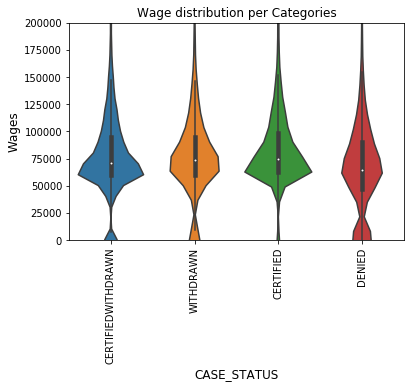

In [30]:
plt.figure()
sns.violinplot(x="CASE_STATUS", 
               y=h1b_data.WAGE_RATE_OF_PAY_FROM, 
               data=h1b_data)
plt.xticks(rotation='vertical')
plt.xlabel('CASE_STATUS', fontsize=12)
plt.ylabel('Wages', fontsize=12)
plt.title("Wage distribution per Categories")
plt.ylim((0, 200000))
plt.show()

In [61]:
h1b_data['submitted_date'] = pd.to_datetime((
    h1b_data.CASE_SUBMITTED_YEAR*10000+
    h1b_data.CASE_SUBMITTED_MONTH*100+
    h1b_data.CASE_SUBMITTED_DAY).apply(str),
    format='%Y%m%d')

h1b_data['decision_date'] = pd.to_datetime((
    h1b_data.DECISION_YEAR*10000+
    h1b_data.DECISION_MONTH*100+
    h1b_data.DECISION_DAY).apply(str),
    format='%Y%m%d')

h1b_data['time_diff'] = (h1b_data['decision_date'] - 
                         h1b_data['submitted_date']).dt.days

In [58]:
# Only looking at Denied and Certified categories
selected = h1b_data[h1b_data.CASE_STATUS.apply(lambda x: 
                                    x in ['CERTIFIED', 'DENIED'])]

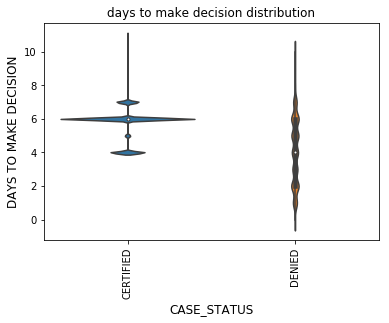

In [62]:
plt.figure()
sns.violinplot(x="CASE_STATUS", 
               y=selected.time_diff, 
               data=selected)
plt.xticks(rotation='vertical')
plt.xlabel('CASE_STATUS', fontsize=12)
plt.ylabel('DAYS TO MAKE DECISION', fontsize=12)
plt.title("days to make decision distribution")
plt.show()